In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

In [ ]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [ ]:
features = []
labels = []
rawdata_path = "/content/drive/MyDrive/Maxi/speech-emotion-recognition-ravdess-data"
for actor in os.listdir(rawdata_path):
    actor_path = os.path.join(rawdata_path, actor)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            emotion_code = file_name.split("-")[2]
            emotion_label = emotion_dict.get(emotion_code)
            file_path = os.path.join(actor_path, file_name)
            mfccs = extract_features(file_path)
            features.append(mfccs)
            labels.append(emotion_label)

features = np.array(features)
labels = np.array(labels)

In [ ]:

labels_df = pd.DataFrame(labels, columns=['Emotions'])
features_df = pd.DataFrame(features)

X = features_df.iloc[:, :-1].values
Y = labels_df['Emotions'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((1152, 39, 1), (1152, 8), (288, 39, 1), (288, 8))

In [ ]:
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.5),

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.5),

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.5),

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 39, 512)           3072      
                                                                 
 batch_normalization_6 (Bat  (None, 39, 512)           2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 20, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 512)           1311232   
                                                                 
 batch_normalization_7 (Bat  (None, 20, 512)           2048      
 chNormalization)                                                
                                                      

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[])

encoder2 = {1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Fear', 7: 'Disgust', 8: 'Surprise'}

audio_file_path = '/content/drive/MyDrive/Maxi/speech-emotion-recognition-ravdess-data/Actor_02/03-01-01-01-01-01-02.wav'
audio_data, sr = librosa.load(audio_file_path, sr=None)

mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=39)
mfccs = mfccs.T

mfccs = np.expand_dims(mfccs, axis=-1)

Epoch 1/100
18/18 [==============================] - 18s 1s/step - loss: 0.3975 - accuracy: 0.8663 - val_loss: 1.9744 - val_accuracy: 0.5312
Epoch 2/100
18/18 [==============================] - 9s 471ms/step - loss: 0.3809 - accuracy: 0.8646 - val_loss: 2.1121 - val_accuracy: 0.5278
Epoch 3/100
18/18 [==============================] - 10s 542ms/step - loss: 0.4160 - accuracy: 0.8550 - val_loss: 2.2799 - val_accuracy: 0.4965
Epoch 4/100
18/18 [==============================] - 9s 533ms/step - loss: 0.3819 - accuracy: 0.8715 - val_loss: 2.0852 - val_accuracy: 0.5417
Epoch 5/100
18/18 [==============================] - 8s 458ms/step - loss: 0.3504 - accuracy: 0.8793 - val_loss: 1.9659 - val_accuracy: 0.5451
Epoch 6/100
18/18 [==============================] - 10s 551ms/step - loss: 0.3464 - accuracy: 0.8811 - val_loss: 1.8399 - val_accuracy: 0.5556
Epoch 7/100
18/18 [==============================] - 9s 531ms/step - loss: 0.3354 - accuracy: 0.8802 - val_loss: 2.6247 - val_accuracy: 0.4757

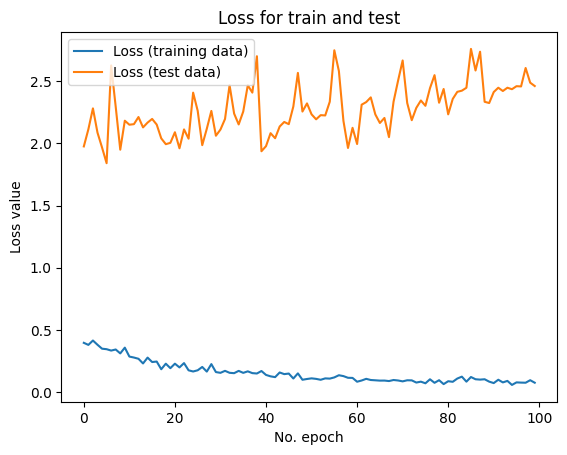

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (test data)')
plt.title('Loss for train and test')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

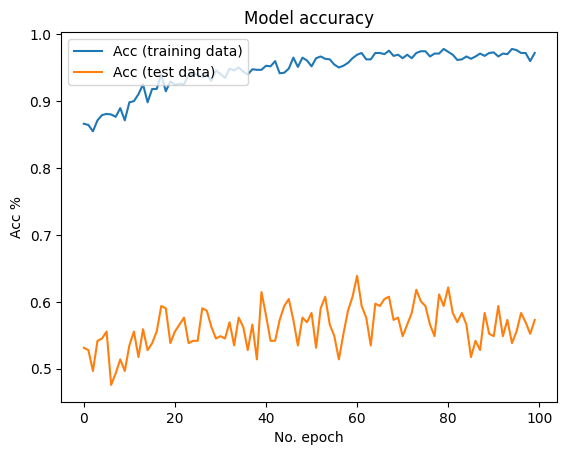

In [ ]:
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (test data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
loss,acc = model.evaluate(x_testcnn, y_test)

9/9 [==============================] - 0s 41ms/step - loss: 2.4593 - accuracy: 0.5729


9/9 [==============================] - 1s 46ms/step


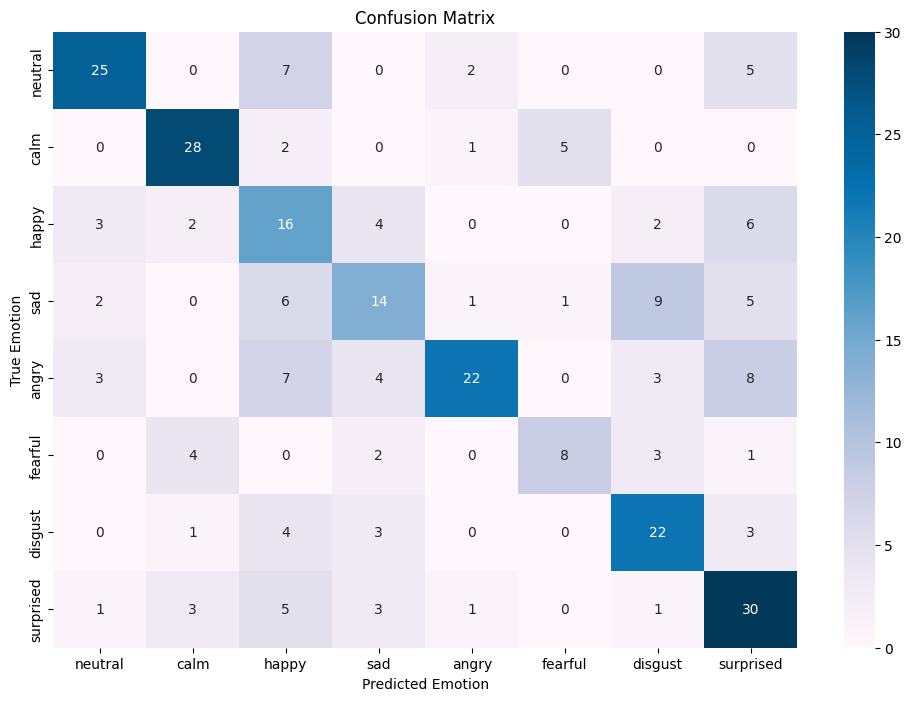

In [ ]:

x_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

x_testcnn = np.expand_dims(x_test_scaled, axis=2)

predictions = model.predict(x_testcnn)
y_pred_class = np.argmax(predictions, axis=1)
y_test_class = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm, index=index, columns=index)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, cmap='PuBu', annot=True, fmt='d')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()